In [1]:
import os
import time
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import *

import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

2023-06-24 19:35:38.313022: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path = os.getcwd() + "/dataset/"
path

'/root/dataset/'

In [3]:
TRAINING_DIR = path+"/train"
VALIDATION_DIR = path + "/val"
TEST_DIR = path + "/test"

print(TRAINING_DIR)
print(VALIDATION_DIR)
print(TEST_DIR)

/root/dataset//train
/root/dataset//val
/root/dataset//test


In [4]:
def data_loader(path):
    X = []
    Y = []
    for folder in os.listdir(path):
        for file in os.listdir(os.path.join(path, folder)):
            feature = np.load(os.path.join(path, folder, file))
            label = folder
            X.append(feature)
            Y.append(label)
    return X, Y

In [5]:
X_train, Y_train = data_loader(TRAINING_DIR)
X_val, Y_val = data_loader(VALIDATION_DIR)
X_test, Y_test = data_loader(TEST_DIR)

In [6]:
print("There are {} training samples and {} training labels".format(len(X_train), len(Y_train)))
print("There are {} validation samples and {} validation labels".format(len(X_val), len(Y_val)))
print("There are {} testing samples and {} testing labels".format(len(X_test), len(Y_test)))

There are 14000 training samples and 14000 training labels
There are 2000 validation samples and 2000 validation labels
There are 4000 testing samples and 4000 testing labels


In [7]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)
Y_test = np.array(Y_test)

print("Shape of X_train: {}".format(X_train.shape))
print("Shape of X_val: {}".format(X_val.shape))
print("Shape of X_test: {}".format(X_test.shape))

Shape of X_train: (14000, 64575)
Shape of X_val: (2000, 64575)
Shape of X_test: (4000, 64575)


In [8]:
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train)
Y_val = label_encoder.fit_transform(Y_val)
Y_test = label_encoder.fit_transform(Y_test)

In [9]:
# Reshape the input data
X_train = X_train.reshape( (X_train.shape[0], X_train.shape[1], 1) )
X_val = X_val.reshape( (X_val.shape[0], X_val.shape[1], 1) )
X_test = X_test.reshape( (X_test.shape[0], X_test.shape[1], 1) )
Y_train = np.asarray(Y_train).astype('float32').reshape((-1,1))
Y_train = np.asarray(Y_train).astype('float32').reshape((-1,1))
Y_test = np.asarray(Y_test).astype('float32').reshape((-1,1))

print("Shape of X_train: {}".format(X_train.shape))
print("Shape of X_val: {}".format(X_val.shape))
print("Shape of X_test: {}".format(X_test.shape))

Shape of X_train: (14000, 64575, 1)
Shape of X_val: (2000, 64575, 1)
Shape of X_test: (4000, 64575, 1)


In [10]:
# shuffle the dataset
shuffle_index = np.random.permutation(len(X_train))
X_train, Y_train = X_train[shuffle_index], Y_train[shuffle_index]
shuffle_index = np.random.permutation(len(X_val))
X_val, Y_val = X_val[shuffle_index], Y_val[shuffle_index]
shuffle_index = np.random.permutation(len(X_test))
X_test, Y_test = X_test[shuffle_index], Y_test[shuffle_index]

In [11]:
X_train.shape

(14000, 64575, 1)

In [12]:
model = Sequential([
    layers.Input(shape=(X_train.shape[1:])),
    layers.Conv1D(16, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

2023-06-24 19:35:51.891951: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22078 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:81:00.0, compute capability: 8.9


In [13]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'],
             )
# tf.keras.losses.BinaryCrossentropy()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 64573, 16)         64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 32286, 16)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 32284, 32)         1568      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 16142, 32)        0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 16140, 64)         6208      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 8070, 64)         0

In [14]:
earlystopper = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

In [15]:
epochs = 200
stop_training_callback = earlystopper
history = model.fit(X_train, Y_train, 
                    epochs=epochs, 
                    validation_data=(X_val, Y_val),
                    batch_size = 128,
                    callbacks=[stop_training_callback])

Epoch 1/200


2023-06-24 19:35:57.996870: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-24 19:35:59.419455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-24 19:35:59.442039: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fd6990f8ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-24 19:35:59.442124: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-06-24 19:35:59.470273: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-24 19:35:59.750365: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

110/110 [==============================] - 20s 113ms/step - loss: 0.5126 - accuracy: 0.7334 - val_loss: 0.3820 - val_accuracy: 0.8330
Epoch 2/200
110/110 [==============================] - 11s 96ms/step - loss: 0.3781 - accuracy: 0.8275 - val_loss: 0.3262 - val_accuracy: 0.8540
Epoch 3/200
110/110 [==============================] - 10s 95ms/step - loss: 0.3348 - accuracy: 0.8466 - val_loss: 0.3185 - val_accuracy: 0.8620
Epoch 4/200
110/110 [==============================] - 10s 95ms/step - loss: 0.3014 - accuracy: 0.8619 - val_loss: 0.3009 - val_accuracy: 0.8670
Epoch 5/200
110/110 [==============================] - 10s 95ms/step - loss: 0.2659 - accuracy: 0.8779 - val_loss: 0.2524 - val_accuracy: 0.8940
Epoch 6/200
110/110 [==============================] - 10s 94ms/step - loss: 0.2403 - accuracy: 0.8921 - val_loss: 0.2299 - val_accuracy: 0.8990
Epoch 7/200
110/110 [==============================] - 10s 95ms/step - loss: 0.2313 - accuracy: 0.8932 - val_loss: 0.2522 - val_accuracy: 0.8

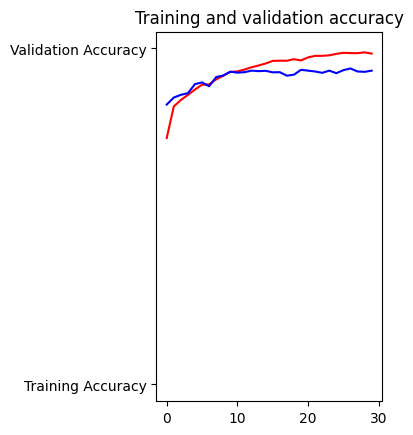

AttributeError: module 'matplotlib' has no attribute 'pyplot'

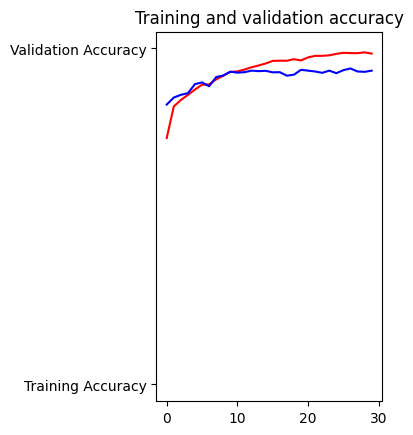

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [16]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [17]:
test_predict = model.predict(X_test)

125/125 [==============================] - 1s 7ms/step


In [18]:
show_test_predict = np.round(test_predict, 0)
show_test_predict = pd.DataFrame(show_test_predict)
print(show_test_predict)
print(len(show_test_predict))

        0
0     0.0
1     0.0
2     0.0
3     0.0
4     1.0
...   ...
3995  1.0
3996  1.0
3997  1.0
3998  1.0
3999  0.0

[4000 rows x 1 columns]
4000


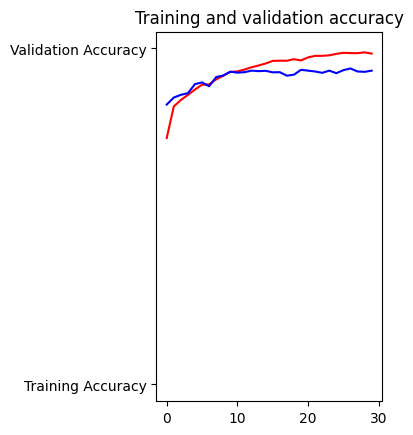

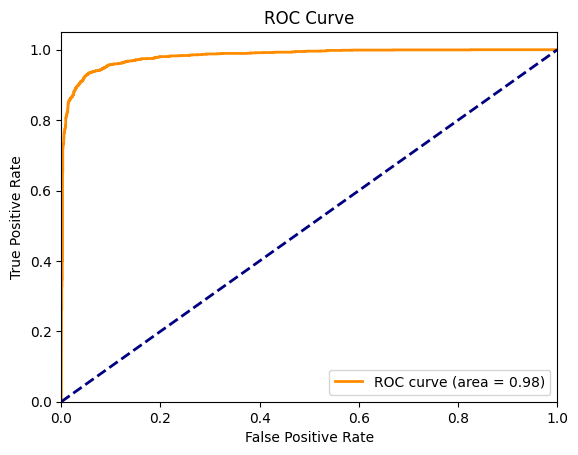

AttributeError: module 'matplotlib' has no attribute 'pyplot'

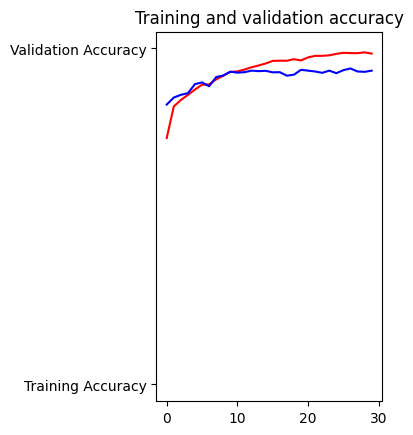

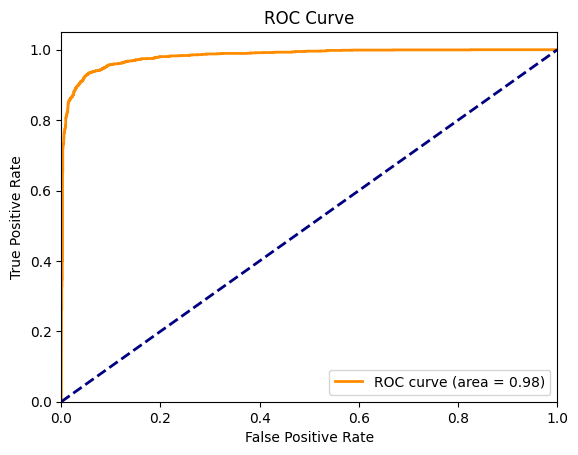

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [19]:
fpr, tpr, thresholds = roc_curve(Y_test, test_predict)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)'% roc_auc)
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
f1_score(Y_test, show_test_predict, average='macro')

In [20]:
confusion_matrix = confusion_matrix(Y_test, show_test_predict)
display(confusion_matrix)

array([[1884,  116],
       [ 131, 1869]])

AttributeError: module 'matplotlib' has no attribute 'axes'

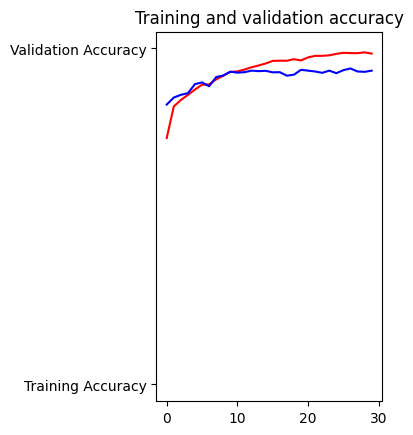

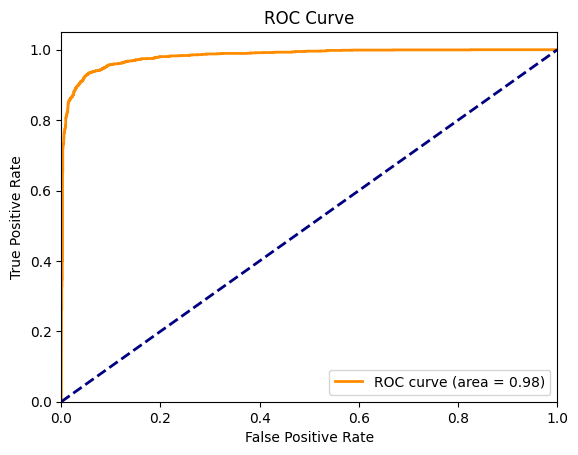

<Figure size 640x480 with 0 Axes>

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [21]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()

In [22]:
model.evaluate(X_test, Y_test)

125/125 [==============================] - 1s 8ms/step - loss: 0.1796 - accuracy: 0.9383


[0.17956171929836273, 0.9382500052452087]

In [23]:
model.save("1D_CNN.h5")